# Exercise 8 – Fit an Hubble Diagram


## The SN Ia Science in short

The Type Ia Supernova event is the thermonuclear runaway of a white dwarf. This bright event is extremely stable and the maximum of luminosity of any explosion reaches roughly the same maximum magnitude `M0`. Two additional parameters: the speed of evolution of the explosion `x1` (also called stretch) and the color of the event `color` enable to further standardize the SN maximum of luminosity. Thanks to the statibility of the absolute SN magnitude, the observation of the effective SN magnitude is a direct indication of the event's distance. Combined with the redshift measurement of the Supernovae -the redshift tracing the overall expansion of the Universe since the SN event- we can measurment the history of the expansion of the Universe. The magnitude vs. redshift plot is called an Hubble Diagram and the Hubble diagram of the SNe Ia enabled the discovery of the accelerated expansion of the Universe in 1999, and thereby of the existance of dark energy (Noble 2011)

## Data you have to measures the density Dark Energy

The latest compilation of Type Ia Supernovae Data has ~1000 SN Ia distance measurements. The data are registered
in 

`notebooks/data/SNeIaCosmo/jla_lcparams.txt`

## The Model

In this example we will use the most straightforward analysis. The stretch and color corrected magnitude of the SNe Ia is:

$$
mb_{corr} = mb - (x1 \times \alpha - color \times \beta)
$$

The expected magnitude of the SNe Ia is:

$$
mb_{expected} = \mu \left(z, \Omega \right) + M_0
$$

where $\mu\left(z, \Omega \right)$ is the distance modulus (distance in log scale) for a given cosmology. To have access to $\mu$ use `astropy`. 

In the flat Lambda CDM model, the only free cosmological parameter you can fit is `Omega_m`, the density of matter today, knowing that, in that case, the density of dark energy is `1-Omega_m`

#### Astropy

The website with all the information is here http://www.astropy.org/

If you installed python using Anaconda, you should have astropy. Otherwise `sudo pip install astropy` should work

To get the cosmology for an Hubble Constant of 70 (use that) and for a given density of matter (Omega_m, which will be one of your free parameter):
```python
from astropy import cosmology
cosmo = cosmology.FlatLambdaCDM(70, Omega_m)
```
To get the distance modulus
```python
from astropy import cosmology
mu = cosmology.FlatLambdaCDM(70, Omega_m).distmod(z).value
```




## Your Job: find the density of Dark energy

Create a Chi2 fitting class that enables to derive the density of dark energy. You should find `Omega_m~0.3` so a universe composed of ~70% of dark energy and 30% of matter

Plot an Hubble diagram showing the corrected SN mangitude (`mb_corr`) as a function of the redshift (`zcmb`). Overplot the model. 

**Remark** `alpha` `beta` and `M0` have to be fitted together with the cosmology, we call that 'nuisance parameters'

**Remark 2** ignore errors on the redshift (`z`), but take into account errors on `mb` and on the `x1` and `color` parameters. For this example ignore the covariance terms.

***
# Correction 
***

In [1]:
import warnings
# No annoying warnings
warnings.filterwarnings('ignore')
# Because we always need that
# plot within the notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as mpl

## First Steps access the Data

#### Import for the cosmological analysis (an also the convenient table)

In [4]:
from astropy import table, cosmology

#### Read the data

In [17]:
data = table.Table.read("data/SNeIaCosmo/jla_lcparams.txt", format="ascii")

In [18]:
data.colnames

['name',
 'zcmb',
 'zhel',
 'dz',
 'mb',
 'dmb',
 'x1',
 'dx1',
 'color',
 'dcolor',
 '3rdvar',
 'd3rdvar',
 'cov_m_s',
 'cov_m_c',
 'cov_s_c',
 'set',
 'ra',
 'dec',
 'biascor']

## The Chi2 Method

an introduction of the "property" and "setter" decorators

decorators are kind-of functions of function. Check e.g., http://thecodeship.com/patterns/guide-to-python-function-decorators/

In [71]:
# copy paste of a class build before

class Chi2Fit( object ):
    
    def __init__(self, jla_data=None):
        """ init the class
        
        Parameters:
        -----------
        jla_data: [astropy.table]
            Astropy Table containing the Supernovae properties
            (zcmb, mb, x1, color etc.)
        
        Return
        ------
        Void
        """
        if jla_data is not None:
            self.set_data(jla_data)

    # ------------------- #
    #   Setter            #
    # ------------------- #        
    def set_data(self, datatable):
        """ Set the data of the class. This must be an astropy table """
        # use this tricks to forbid the user to overwrite self.data...
        self._data = datatable
        
        
        
        
        
    def setup(self, parameters):
        """ Set the parameters of the class: 
        - alpha
        - beta
        - Om
        - M0
        """
        self._parameters = parameters  
        
    # ------------------- #
    #   GETTER            #
    # ------------------- #
    def get_mbcorr(self, parameters):
        """ corrected sn magnitude with its associated variance"""
        return self.mb - (self.x1*parameters[0] + self.color*parameters[1]),\
            self.mb_err**2 + (self.x1*parameters[0])**2 + (self.color*parameters[1])**2
    
    def get_mbexp(self, parameters, z=None):
        """ corrected sn magnitude with its associated error"""
        zused = z if z is not None else self.zcmb
        return cosmology.FlatLambdaCDM(70, parameters[2]).distmod(zused ).value + parameters[3]
        
    
    def fit(self,guess):
        """ fit the model to the data 
        
        The methods uses scipy.optimize.minize to fit the model 
        to the data. The fit output is saved as self.fitout, the 
        best fit parameters being self.fitout["x"]
        
        Parameters
        ----------
        guess: [array]
            initial guess for the minimizer. It's size must correspond
            to the amount of free parameters of the model.
            
        Return
        ------
        Void (create self.fitout)
        """
        from scipy.optimize import minimize
        bounds = [[None,None],[None,None],[0,None],[None,None]]
        self.fitout = minimize(self.chi2, guess,bounds=bounds)
        print self.fitout
        self._bestfitparameters = self.fitout["x"]
 
    def chi2(self,parameters):
        """ The chi2 of the model with the given `parameters` 
        in comparison to the object's data 
        
        Return
        ------
        float (the chi2)
        """
        mbcorr, mbcorr_var = self.get_mbcorr(parameters)
        mb_exp = self.get_mbexp(parameters)
        chi2 = ((mbcorr-mb_exp)**2)/(mbcorr_var)
        
        return np.sum(chi2)
    
    def plot(self, parameters):
        """ Vizualize the data and the model for the given
        parameters
        
        Return
        ------
        Void
        """
        fig = mpl.figure()
        ax = fig.add_subplot(1,1,1)
        
        self.setup(parameters)
        
        ax.errorbar(self.zcmb,self.setted_mbcorr, 
                    yerr=self.setted_mbcorr_err, ls="None",marker='o', color="b", 
                    ecolor="0.7")
        x = np.linspace(0.001,1.4,10000)
            #print self.get_cosmo_distmod(parameters,x)
        ax.plot(x,self.get_mbexp(self._parameters,x),'-r', scalex=False,scaley=False)
        fig.show()
        
        
    # ================== #
    #  Properties        #
    # ================== #
    @property
    def data(self):
        """ Data table containing the data of the instance """
        return self._data

    @data.setter
    def data(self, newdata):
        """ Set the data """
        # add all the relevant tests
        print "You setted new data"
        self._data = newdata
    
    @property
    def npoints(self):
        """ number of data points """
        return len(self.data)
    
    # ----------
    # - Parameters
    
    @property
    def parameters(self):
        """ Current parameters of the fit """
        if not self.has_parameters():
            raise ValueError("No Parameters defined. See the self.setup() method")
        return self._parameters
    
    def has_parameters(self):
        return "_parameters" in dir(self)
    
    
    
    
    # -- Current Param prop
    @property
    def _alpha(self):
        return self._parameters[0]
    @property
    def _beta(self):
        return self._parameters[1]
    @property
    def _omegam(self):
        return self._parameters[2]
    @property
    def _M0(self):
        return self._parameters[3]
    
    # -------
    # -- Param derived properties
    @property
    def setted_mbcorr(self):
        """ corrected hubble residuals"""
        return self.get_mbcorr(self.parameters)[0]
    @property
    def setted_mbcorr_err(self):
        """ corrected hubble residuals"""
        return np.sqrt(self.get_mbcorr(self.parameters)[1])
    
    @property
    def setted_mu(self):
        """ distance modulus for the given cosmology """
        return cosmology.FlatLambdaCDM(70, _omegam).distmod(self.zcmb).value
    
    @property
    def setted_M0(self):
        """ absolute SN magnitude for the setted parameters """
        return self._M0
    
    @property
    def setted_mbexp(self):
        return self.setted_mu + self._M0
    # -------
    # -- Data derived properties
    @property
    def mb(self):
        """ observed magnitude (in the b-band) of the Supernovae """
        return self.data["mb"]
    
    @property
    def mb_err(self):
        """ observed magnitude (in the b-band) of the Supernovae """
        return self.data["dmb"]
    
    @property
    def x1(self):
        """ Lightcurve stretch """
        return self.data["x1"]
    
    @property
    def x1_err(self):
        """ errors on the Lightcurve stretch """
        return self.data["dx1"]
        
    @property
    def color(self):
        """ Lightcurve color """
        return self.data["color"]
    
    @property
    def color_err(self):
        """ errors on the Lightcurve color """
        return self.data["dcolor"]
    
    @property
    def zcmb(self):
        """ cosmological redshift of the Supenovae """
        return self.data["zcmb"]
    
    

In [72]:
c = Chi2Fit(data)

In [75]:
c.setup([ -0.18980149,   3.65435315,   0.32575054, -19.06810566])

In [78]:
c.setted_mbcorr

23.2884937733
23.8505058822
23.1860815365
22.3271927061
24.3394763851
23.411729863
24.6563282585
22.0490903156
24.5143846363
23.1350221599
22.5801859785


In [47]:
c.fit([0.13,3,0.2,-20])

      fun: 317.79605552693431
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.68434189e-04,  -5.11590770e-05,   2.89901436e-04,
        -2.27373675e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 320
      nit: 35
   status: 0
  success: True
        x: array([ -0.18980149,   3.65435315,   0.32575054, -19.06810566])


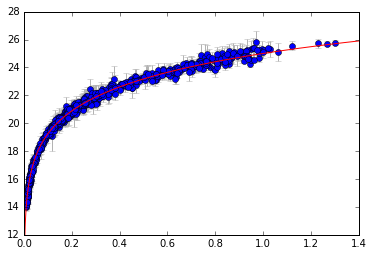

In [48]:
c.plot(c._bestfitparameters)

In [50]:
c.setted_mbcorr

23.288493773
23.850505882
23.186081537
22.3271927065
24.3394763851
23.4117298636
24.6563282586
22.0490903155
24.5143846368
23.13502216
22.5801859785
